Teamnaam: Ongeneeselijk dakloos

Teamleden:
1. needanku (Tijn)
2. jipschijvenaars (Jip)
3. joesvandeursen (Joes)
4. jimaugustinus (Jim)


## Importeren libraries

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy.fft import fft
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

#basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Fourier analysis
from scipy.fft import fft, ifft
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

#Regression libraries
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error as mse

#metrics and CV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, KFold
import math

In [274]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

display(train_data.head(5))
display(test_data.head(5))

## Exploratieve Data Analyse

In [172]:
display(train_data.dtypes)
display(train_data.describe())

In [173]:
train_data['date_hour'] = pd.to_datetime(train_data['date_hour'])

train_data.set_index('date_hour', inplace=True)

plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data['cnt'], color='blue', label='Count of Rentals')
plt.title('Time Series of Rentals')
plt.xlabel('Date Hour')
plt.ylabel('Count of Rentals')
plt.legend()
plt.grid()
plt.show()


In [174]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.scatterplot(data=train_data, x='temp', y='cnt', color='orange')
plt.title('Temperature vs Count of Rentals')
plt.xlabel('Temperature')
plt.ylabel('Count of Rentals')

plt.subplot(2, 2, 2)
sns.scatterplot(data=train_data, x='hum', y='cnt', color='green')
plt.title('Humidity vs Count of Rentals')
plt.xlabel('Humidity')
plt.ylabel('Count of Rentals')

plt.subplot(2, 2, 3)
sns.scatterplot(data=train_data, x='windspeed', y='cnt', color='red')
plt.title('Windspeed vs Count of Rentals')
plt.xlabel('Windspeed')
plt.ylabel('Count of Rentals')

plt.subplot(2, 2, 4)
sns.boxplot(data=train_data, x='weathersit', y='cnt', palette='Set2')
plt.title('Weather Situation vs Count of Rentals')
plt.xlabel('Weather Situation')
plt.ylabel('Count of Rentals')

plt.tight_layout()
plt.show()

1. De tijdrijgrafiek laat zien dat verhuur duidelijke seizoenspatronen heeft, met pieken tijdens bepaalde periodes van het jaar.  
2. Er is een positieve correlatie tussen temperatuur en het aantal verhuur, wat suggereert dat hogere temperaturen leiden tot meer verhuur.  
3. Luchtvochtigheid lijkt een negatief effect te hebben op verhuur; naarmate de luchtvochtigheid toeneemt, neemt het aantal verhuurd af.  
4. Windsnelheid toont een zwakke negatieve correlatie met verhuur, wat erop wijst dat hogere windsnelheden gebruikers kunnen ontmoedigen om te huren.  
5. De boxplot voor weersituatie laat zien dat bepaalde weersomstandigheden (zoals helder of licht bewolkt) geassocieerd zijn met hogere aantallen verhuur in vergelijking met andere omstandigheden (zoals regen of sneeuw).  


### Data cleaning

In [175]:
missing_values = train_data.isnull().sum()
duplicates = train_data.duplicated().sum()

print('Missing Values per Column:')
print(missing_values)
print(f'Total Duplicates: {duplicates}')

Er zijn geen missende waarde, wel zijn er 106 dubbele rijen. Door deze te verwijderen maken we de dataset uniek en consistent.

In [176]:
train_data_cleaned = train_data.drop_duplicates()
cleaned_shape = train_data_cleaned.shape

print(f'Original shape: {train_data.shape}')
print(f'Cleaned shape: {cleaned_shape}')

### Relevantie bepalen

In [177]:
correlation_matrix = train_data_cleaned.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

- We berekenen de correlatie om te zien welke gegevens belangrijk kunnen zijn.
- We kiezen de kolommen die nuttig zijn.
- We maken een kleinere, overzichtelijke dataset waarmee je verder kunt werken.

## Time series feature engineering

In [178]:
train_data_final = train_data_cleaned.copy()

In [179]:
train_data_final['year'] = train_data_final.index.year
train_data_final['month'] = train_data_final.index.month
train_data_final['day'] = train_data_final.index.day
train_data_final['day_of_week'] = train_data_final.index.dayofweek
train_data_final['quarter'] = train_data_final.index.quarter

train_data_final['sin_month'] = np.sin(2 * np.pi * train_data_final['month'] / 12)
train_data_final['cos_month'] = np.cos(2 * np.pi * train_data_final['month'] / 12)

train_data_final.head()


We voegen extra kolommen toe aan onze dataset om meer informatie uit de datum-index te halen. Deze extra gegevens kunnen ons helpen om patronen en trends beter te begrijpen en ons model te verbeteren.

We halen het jaar, maand, dag, dag van de week en het kwartaal uit de datum-index:
- Zo kunnen we analyseren of er bepaalde trends zijn die te maken hebben met tijd.

Seizoenspatronen toevoegen met sinus en cosinus:
- We gebruiken de maand en zetten deze om in sinus- en cosinuswaarden. Dit is handig om seizoensgebonden patronen te modelleren, zoals veranderingen door de tijd heen.
- Door sinus en cosinus te gebruiken, geven we onze dataset een cyclische structuur: januari (maand 1) en december (maand 12) liggen hierdoor dicht bij elkaar, wat logischer is voor maandelijkse trends.

In [ ]:
cnt_values = train_data_cleaned['cnt'].values

fourier_transform = fft(cnt_values)

n = len(cnt_values)
frequencies = np.fft.fftfreq(n)

plt.figure(figsize=(12, 6))
plt.plot(frequencies, np.abs(fourier_transform))
plt.title('Fourier Transform of Rentals')
plt.xlabel('Frequency (1/hour)')
plt.ylabel('Magnitude')
plt.xlim(0, 0.51)
plt.grid()
plt.show()

Piek rond 0.04:
- Dit suggereert een belangrijke cyclische trend. Als we dit om rekenen naar uren krijgen we 1/0.04 = 25. Omdat de exacte waarde moeilijk af te lezen is het waarschijnlijker dat dit over 24 uur gaat, een hele dag. In de data is er dus een dagelijks patroon aanwezig.

Andere pieken:
- Er zijn kleinere pieken op andere frequenties tussen de 0.07 en 0.09. Dit wijst op minder sterke terugkerende patronen.

Hobbels:
- Er zijn nog een paar hobbels te zien, maar deze hebben een te lage magnitude om relevant te zijn.

In [182]:
plt.figure(figsize=(14, 7))
plt.plot(train_data_final.index, train_data_final['cnt'], color='blue')
plt.title('Time Series of Rentals (cnt)')
plt.xlabel('Date')
plt.ylabel('Number of Rentals')
plt.grid()
plt.show()

### Seizoensgebonden trends:
- In de lente en zomer (rond het midden van 2011 en 2012) zie je een duidelijke toename in het aantal verhuur. Dit kan worden toegeschreven aan het betere weer in die perioden.
- In de herfst en winter (eind 2011 en 2012) zie je een daling, waarschijnlijk door kouder weer en minder gunstige weersomstandigheden voor verhuren.

### Langzame groei in 2011:
- Het aantal verhuur stijgt geleidelijk in het eerste jaar (2011). Dit kan te maken hebben met een groeiende populariteit of uitbreiding van de verhuurdienst.

### Schommelingen:
- Je ziet dagelijkse of wekelijkse pieken en dalen. Mogelijk zijn dit weekdagen versus weekends, waarbij verhuur in het weekend hoger is.

### Sterkere verhuur in 2012:
- In 2012 lijkt het gemiddeld aantal verhuur per dag hoger te liggen dan in 2011.

### Seizoenspiek in de zomer:
- De hoogste waarden (bijvoorbeeld in de zomer van 2012) wijzen op maximale drukte in die periode.


In [ ]:
# Er is voor een lag van 50 gekozen omdat dit het patroon per dag duidelijk zichtbaar maakt.
plot_acf(train_data_cleaned['cnt'], lags=50)
plt.title('Autocorrelation Function (ACF) of Rentals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid()
plt.show()

De ACF meet hoe sterk de waarde van het aantal verhuur op een specifieke dag (de "lag 0") correleert met de waarden van eerdere dagen (bijvoorbeeld "lag 1", "lag 2", enz.). Dit helpt ons patronen in de tijdreeksen te begrijpen.

- Ook hier is er een patroon van 24 uur te herkennen.

## Time Series Feature Engineering

In [ ]:
train_data_final['is_weekend'] = train_data_final['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0)
train_data_final['season'] = train_data_final['month'].apply(lambda x: 'winter' if x in [12, 1, 2] else 'spring' if x in [3, 4, 5] else 'summer' if x in [6, 7, 8] else 'autumn')
train_data_final['is_spring'] = train_data_final['season'].apply(lambda x: 1 if x == 'spring' else 0)
train_data_final['is_summer'] = train_data_final['season'].apply(lambda x: 1 if x == 'summer' else 0)
train_data_final['is_autumn'] = train_data_final['season'].apply(lambda x: 1 if x == 'autumn' else 0)
train_data_final['is_winter'] = train_data_final['season'].apply(lambda x: 1 if x == 'winter' else 0)

train_data_final['temp_atemp_diff'] = train_data_final['temp'] - train_data_final['atemp']
train_data_final['hum_windspeed_interaction'] = train_data_final['hum'] * train_data_final['windspeed']

train_data_final['sin_day_of_week'] = np.sin(2 * np.pi * train_data_final['day_of_week'] / 7)
train_data_final['cos_day_of_week'] = np.cos(2 * np.pi * train_data_final['day_of_week'] / 7)

train_data_final['is_month_end'] = train_data_final['day'] >= 25


train_data_final['temp_month_rel'] = train_data_final['temp'] / train_data_final.groupby('month')['temp'].transform('mean')
train_data_final['hum_month_rel'] = train_data_final['hum'] / train_data_final.groupby('month')['hum'].transform('mean')

train_data_final['is_heatwave'] = train_data_final['temp'] > 30
train_data_final['is_storm'] = train_data_final['windspeed'] > 40

train_data_final['windspeed_change'] = train_data_final['windspeed'] - train_data_final['windspeed'].shift(1)

train_data_final['temp_diff_from_max'] = train_data_final['temp'] - train_data_final.groupby('month')['temp'].transform('max')
train_data_final['temp_windspeed_interaction'] = train_data_final['temp'] * train_data_final['windspeed']

train_data_final['lagged_temp'] = train_data_final['temp'].shift(1)
train_data_final['lagged_hum'] = train_data_final['hum'].shift(1)
train_data_final['lagged_weathersit'] = train_data_final['weathersit'].shift(1)


display(train_data_final.head())
display(train_data_final.columns)
display(train_data_final.shape)

# Uitleg van Toegevoegde Kenmerken

## Tijdsgebaseerde Kenmerken
- **`is_weekend`**  
  Geeft aan of het een zaterdag of zondag is (`1`) of niet (`0`).

- **`season`**  
  Verdeelt de maanden in winter, lente, zomer en herfst:  
  - Extra kolommen zoals `is_spring`, `is_summer`, enz., markeren of een datum in dat seizoen valt (`1`) of niet (`0`).  
  - Dit helpt bij het modelleren van seizoensinvloeden.

## Weergerelateerde Kenmerken
- **`temp_atemp_diff`**  
  Kijkt naar het verschil tussen de gemeten en gevoelstemperatuur.

- **`hum_windspeed_interaction`**  
  Combineert luchtvochtigheid en windsnelheid, wat weersomstandigheden beter samenvat.

## Cyclische Patronen
- **`sin_day_of_week` en `cos_day_of_week`**  
  Leggen vast dat dagen van de week een cyclisch patroon volgen (bijvoorbeeld maandag komt na zondag).

## Relaties met Maandgemiddelden
- **`temp_month_rel` en `hum_month_rel`**  
  Tonen hoe temperatuur en luchtvochtigheid zich verhouden tot het maandgemiddelde.

## Bijzondere Dagen
- **`is_heatwave`**  
  Markeert dagen met een temperatuur boven 30 graden.

- **`is_month_end`**  
  Geeft aan of een dag in de laatste week van de maand valt.

## Veranderingen en Interacties
- **`windspeed_change`**  
  Kijkt naar de verandering in windsnelheid vergeleken met de vorige dag.

- **`temp_diff_from_max`**  
  Vergelijkt de temperatuur met de hoogste temperatuur die maand.

- **`temp_windspeed_interaction`**  
  Combineert temperatuur en windsnelheid, wat een invloed kan hebben op verhuur.

## Lagged Kenmerken
- **`lagged_temp`, `lagged_hum`, en `lagged_weathersit`**  
  Gebruiken waarden van de vorige dag om te zien of recente trends een invloed hebben.


In [185]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import randint


# Define features and target
features = ['temp', 'atemp', 'hum', 'windspeed', 'weathersit', 'cnt', 'year',
       'month', 'day', 'day_of_week', 'quarter', 'sin_month', 'cos_month',
       'lag_1', 'lag_2', 'rolling_mean_3', 'rolling_mean_7', 'rolling_std_3',
       'rolling_std_7', 'is_weekend', 'holiday', 'season', 'is_spring',
       'is_summer', 'is_autumn', 'is_winter', 'temp_atemp_diff',
       'hum_windspeed_interaction', 'sin_day_of_week', 'cos_day_of_week',
       'is_month_end', 'temp_month_rel', 'hum_month_rel', 'is_heatwave',
       'is_storm', 'windspeed_change', 'temp_diff_from_max',
       'temp_windspeed_interaction', 'lagged_temp', 'lagged_hum',
       'lagged_weathersit']

# Ensure data is clean and ready
X = train_data_final[features].dropna()
Y = train_data_final['cnt'][X.index]

# Check for non-numeric columns
non_numeric_cols = X.select_dtypes(include=['object', 'category']).columns
print("Non-numeric columns:", non_numeric_cols)

# One-hot encode non-numeric columns (if any)
if 'season' in non_numeric_cols:
    X = pd.get_dummies(X, columns=['season'], drop_first=True)

# Ensure all columns are numeric
assert X.select_dtypes(include=['object', 'category']).shape[1] == 0, "Non-numeric columns remain!"

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Define parameter grid for Randomized Search
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}

# Define scoring metric
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Perform Randomized Search
random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_grid,
    n_iter=10,
    cv=5,
    scoring=scorer,
    verbose=1
)

# Fit the model
random_search.fit(X_train, Y_train)

# Get the best model and parameters
best_model = random_search.best_estimator_
best_params = random_search.best_params_

# Predict on the test set
Y_pred = best_model.predict(X_test)

# Calculate RMSE
rmse = mean_squared_error(Y_test, Y_pred, squared=False)

# Print results
print(f"Best Parameters: {best_params}")
print(f"Best Score: {random_search.best_score_}")
print(f"RMSE: {rmse}")




## Alles in een functie zetten

In [187]:
def remove_duplicates(df):
    return df.drop_duplicates()

def generate_features(df):
    
    # Tijdgerelateerde features
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['quarter'] = df.index.quarter

    # Sinus- en cosinus-transformaties voor cyclic months
    df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
    df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)

    # Lag features
    df['lag_1'] = df['cnt'].shift(1)
    df['lag_2'] = df['cnt'].shift(2)
    
    # Rolling statistics
    df['rolling_mean_3'] = df['cnt'].rolling(window=3).mean()
    df['rolling_mean_7'] = df['cnt'].rolling(window=7).mean()
    df['rolling_std_3'] = df['cnt'].rolling(window=3).std()
    df['rolling_std_7'] = df['cnt'].rolling(window=7).std()
    
    # Weekend and holiday indicators
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0)
    df['is_holiday'] = df['day_of_week'].apply(lambda x: 1 if x in [0, 1] else 0)
    
    # Seasons
    df['season'] = df['month'].apply(
        lambda x: 'winter' if x in [12, 1, 2] else 
                  'spring' if x in [3, 4, 5] else 
                  'summer' if x in [6, 7, 8] else 'autumn'
    )
    df['is_spring'] = df['season'].apply(lambda x: 1 if x == 'spring' else 0)
    df['is_summer'] = df['season'].apply(lambda x: 1 if x == 'summer' else 0)
    df['is_autumn'] = df['season'].apply(lambda x: 1 if x == 'autumn' else 0)
    df['is_winter'] = df['season'].apply(lambda x: 1 if x == 'winter' else 0)
    
    # Feature interactions and transformations
    df['temp_atemp_diff'] = df['temp'] - df['atemp']
    df['hum_windspeed_interaction'] = df['hum'] * df['windspeed']
    
    # Sinusoidal encoding for cyclic features
    df['sin_day_of_week'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['cos_day_of_week'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    
    # Month-end indicator
    df['is_month_end'] = df['day'] >= 25
    
    # Relative features
    df['temp_month_rel'] = df['temp'] / df.groupby('month')['temp'].transform('mean')
    df['hum_month_rel'] = df['hum'] / df.groupby('month')['hum'].transform('mean')
    
    # Weather-related indicators
    df['is_heatwave'] = df['temp'] > 30
    df['is_storm'] = df['windspeed'] > 40
    
    # Wind speed change
    df['windspeed_change'] = df['windspeed'] - df['windspeed'].shift(1)
    
    # Temperature difference from max temperature in the month
    df['temp_diff_from_max'] = df['temp'] - df.groupby('month')['temp'].transform('max')
    
    # Temperature and windspeed interaction
    df['temp_windspeed_interaction'] = df['temp'] * df['windspeed']
    
    # Lagged weather-related features
    df['lagged_temp'] = df['temp'].shift(1)
    df['lagged_hum'] = df['hum'].shift(1)
    df['lagged_weathersit'] = df['weathersit'].shift(1)
    
    return df


In [ ]:
import numpy as np
import pandas as pd

def create_feature_waves_with_generation(df, waves):
    """
    Maakt iteratief nieuwe dataframes met extra features in golven en genereert de features automatisch.
    
    Parameters:
    - df (pd.DataFrame): Originele dataframe met minimaal een tijdindex en 'cnt'-kolom.
    - waves (list of lists): Elke sublijst bevat de namen van features die in een golf worden toegevoegd.
    
    Returns:
    - list of pd.DataFrame: Een lijst met dataframes, elk met meer features dan het vorige.
    """
    dfs = []
    base_features = ['year', 'month', 'day', 'day_of_week', 'quarter', 'sin_month', 'cos_month']  # Basis tijdfeatures
    
    # Maak basis tijdgerelateerde features
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
    df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)
    
    current_features = base_features.copy()

    for wave in waves:
        for feature in wave:
            # Logica voor featureberekeningen
            if feature == 'is_weekend':
                df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0)
            elif feature == 'is_holiday':
                df['is_holiday'] = df['day_of_week'].apply(lambda x: 1 if x in [0, 1] else 0)
            elif feature == 'temp_atemp_diff':
                df['temp_atemp_diff'] = df['temp'] - df['atemp']
            elif feature == 'hum_windspeed_interaction':
                df['hum_windspeed_interaction'] = df['hum'] * df['windspeed']
            elif feature == 'temp_windspeed_interaction':
                df['temp_windspeed_interaction'] = df['temp'] * df['windspeed']
            elif feature == 'windspeed_change':
                df['windspeed_change'] = df['windspeed'] - df['windspeed'].shift(1)
        
        # Voeg de nieuwe features van deze golf toe
        current_features.extend(wave)
        temp_df = df[current_features].copy()  # Maak een nieuw dataframe met de huidige features
        dfs.append(temp_df)  # Voeg dit nieuwe dataframe toe aan de lijst
    
    return dfs


# Opdracht 3: Modelleren

## Class voor modelleren

Hieronder maken wij een class aan waarmee wij de modellen kunnen trainen, voorspellingen kunnen maken en deze evalueren. Hierdoor kunnen wij goed het effect laten zien die de verschillende tijdfeatures hebben op de prestaties van de modellen.

In [290]:
class RegressionModels:
    def __init__(self, data, target, dummie_cols=False, shuffle=True, test_size=0.2, random_state=42):
        self.data = data
        self.scores_df = pd.DataFrame()
        if dummie_cols:
            self.data = pd.get_dummies(self.data, columns=dummie_cols)              
        self.X = self.data.drop(target, axis=1)
        self.y = self.data[[target]]        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y,
                                                                                test_size=test_size, shuffle=shuffle, 
                                                                                random_state=random_state)
        
    def time_series_data(self, order, constant=False, drop=True):
        dp = DeterministicProcess(index=self.y_train.index, constant=constant, order=order, drop=drop)
        self.X_train2 = dp.in_sample()
        self.X_test2 = dp.out_of_sample(steps=len(self.y_test), forecast_index=self.y_test.index)
        
    def concat_data(self):
        self.X_train = pd.concat([self.X_train, self.X_train2], axis=1)
        self.X_test = pd.concat([self.X_test, self.X_test2], axis=1)
        
    def tune_params(self, n_splits, models_dict):
        self.models_dict = models_dict
        self.results = {}
        self.best_model = None
        self.best_params = None
        self.best_score = float('inf')  # for regression
        kf = TimeSeriesSplit(n_splits=n_splits)
        for model in models_dict.items():
            model_cv = GridSearchCV(estimator=model[1][0], param_grid=model[1][1], cv=kf, n_jobs=-1, scoring='neg_root_mean_squared_error')
            model_cv.fit(self.X_train, self.y_train.values.ravel())
            self.results[model[0]] = [model_cv.best_params_, -model_cv.best_score_]  # convert negative RMSE to positive
            print(model[0], self.results[model[0]])
            if -model_cv.best_score_ < self.best_score:
                self.best_score = -model_cv.best_score_
                self.best_model = model[0]
                self.best_params = model_cv.best_params_
        
    def predict(self):
        self.fi = {}
        # dict to store feature importances
        self.model = self.models_dict[self.best_model][0].set_params(**self.best_params)
        print('fit_predict',self.model)
        self.model.fit(self.X_train, self.y_train)
        self.y_test_pred = self.model.predict(self.X_test)
        self.y_train_pred = self.model.predict(self.X_train)
        print(f'train rmse {self.model}', math.sqrt(mse(self.y_train, self.y_train_pred)))
        print(f'test rmse {self.model}', math.sqrt(mse(self.y_test, self.y_test_pred)))
        # only if attribute exists
        if hasattr (self.model, 'feature_importances_'):
                self.fi[self.best_model] = self.model.feature_importances_
                
    def show_feature_importances(self):
        for fi in self.fi.items():
            feature_importance = pd.DataFrame(fi[1])
            cols = pd.DataFrame(self.X_train.columns)
            df_fi = pd.concat([cols, feature_importance], axis=1)
            df_fi.columns = ['feature', 'importance']
            df_fi.sort_values('importance', ascending=True, inplace=True)
            df_fi.plot(kind='barh', x='feature', y='importance', title=fi[0])

    def scores_to_df(self):
        # Genereer een lijst met nieuwe scores
        scores_list = [{'Model': model, 'Score': score[1]} for model, score in self.results.items()]
        new_scores_df = pd.DataFrame(scores_list)
        
        # Voeg nieuwe scores toe aan de bestaande `self.scores_df`, indien van toepassing
        if self.scores_df.empty:  # Als `scores_df` leeg is, initialiseer met de nieuwe scores
            self.scores_df = new_scores_df
        else:  # Voeg anders de nieuwe scores toe, zonder duplicaten
            self.scores_df = pd.concat([self.scores_df, new_scores_df]).reset_index(drop=True)
        
        # Toon het bijgewerkte scores DataFrame
        display(self.scores_df)
      

## *Linieare regressie*

- **Hoe werkt lineaire regressie?**

    Lineaire regressie is een techniek waarmee, bij regressieproblemen, de relatie tussen de afhankelijke variabele $y$ en onafhankelijke variabele(n) $x$ kunnen worden weergeven. 


    De formule voor lineaire regressie is alsvolgt:

    $$\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_p x_p$$
    
    Waarbij:
    - $\hat{y}$ de voorspelde waarde is
    - $x_i$ de feature is
    - $\beta_0$ het snijpunt met de y-as is (intercept)
    - $\beta_i$ het coëffiënt is van de bijbehorende feature

- **Wat is regularisatie?**

    Er bestaan 2 vormen van regularisatie, namelijk $L_{1}$-regularisatie en $L_{2}$-regularisatie. Deze worden ook wel Lasso en Ridge genoemd. Wanneer een model te complex is kan deze verbanden zien tussen datapunten die er helemaal niet zijn. In dit geval is het model te complex en is er sprake van overfitting. Als dit het geval is wordt er gebruik gemaakt van regularisatie om deze overfitting tegen te gaan. Overfitting is meestal te herkennen aan een hele hoge score op de trainingsdata maar een lage score op de testdata.

- **Hoe werkt regularisatie?** 

    Door middel van regularisatie worden de coëfficiënten van de verschillende onafhankelijke variabelen meer in verhouding gebracht. Zo zorgt regularisatie ervoor dat feautures die veel invloed hebben op de uiteindelijke voorspelling een stuk meer meetellen dan features die weinig invloed hebben. Het grote verschil tussen de 2 verschillende vormen van regularisatie is dat bij $L_{1}$-regularisatie de coëfficiënten zo erg 'gestraft' kunnen worden dat deze ook daadwerkelijk 0 worden en dus geen invloed meer hebben op de uiteindelijke voorspelling, bij $L_{2}$-regularisatie is dit niet het geval. De coëfficiënten kunnen hier wel zo goed als 0 worden maar zullen nooit daadwerkelijk 0 zijn en zullen dus altijd bijdragen aan de voorspelling.

- **Toepassen regularisatie** 

    1. $L_{1}$-regularisatie (Lasso)

        De formule van $L_{1}$-regularisatie ziet er als volgt uit:

        $J(w) = RSS + \lambda \sum_{j=1}^{p}|w|_{j}$
        
        *Hieronder staat de betekenis van de verschillende variabelen:*
        - $RSS$: ook wel de *Residual sum of squares* genoemd staat voor de foutterm van de lineaire regressie zelf. 
        -  $\lambda$: Dit is de regularisatieparameter en controleert de mate van regularisatie.
        - $|w|_{j}$: Dit is de L1-norm van de gewichten $w$. Deze bepaald hoe erg alle features worden "gestraft"

    2. $L_{2}$-regularisatie (Ridge)

        De formule van $L_{2}$-regularisatie ziet er als volgt uit:

        $J(w) = RSS + \lambda \sum_{j = 1}^{p} w^{2}_{j}$

        *Hieronder staat de betekenis van de verschillende variabelen:*
        - $RSS$: ook wel de *Residual sum of squares* genoemd staat voor de foutterm van de lineaire regressie zelf. 
        -  $\lambda$: Dit is de regularisatieparameter en controleert de mate van regularisatie.
        - $w^{2}_{j}$: Dit is de L2-norm van de gewichten $w$. Deze bepaald hoe erg alle features worden "gestraft"

- **Loss functie bij lineaire regressie**

    Een loss functie is een wiskundige formule die een waarde geeft aan de fout tussen de voorspellingen die een model maakt en de daadwerkelijke waardes.  De loss functie die bij deze opdracht wordt gebruikt is de *Root Mean Squared Error* (RMSE).

    De formule van de RMSE is alsvolgt:
    
    $\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2}$

    Waarbij:
    - $y_i$ de daadwerkelijke waarde van het datapunt $i$ is
    - $\hat{y}_i$ de voorspelde waarde van het datapunt $i$ is
    - $n$ het aantal datapunten is

    Het verschil tussen RMSE en andere loss functies is dat RMSE erg gevoelig is voor grote fouten. Dit komt doordat deze functie de fouten kwadrateerd. 


## *KNN regressor*

- **Waarom KNN regressor?**

    Er is gekozen voor een KNN regressor omdat we te maken hebben met een regressieprobleem. Daarnaast gaat het in deze dataset om een tijdserie. KNN regressor werkt bij zulk soort problemen goed om de volgende redenen:
    
    1. *Gebruik van patronen in historische data*

        Bij tijdseries kan KNN gebruikt worden om patronen te leren door vergelijkbare patronen in het verleden te identificeren. 
        
        Dit kan nuttig zijn bij:
        - Seizoensgebonden data
        - Terugkerende patronen


    2. Flexibiliteit in feature-engineering

        Bij tijdseries kun je kenmerken (features) afleiden zoals:
        - Gemiddelden, minima, maxima over een bepaalde tijd
        - Lagged-waarden 
        - Seizoensindicatoren

        KNN kan gemakkelijk met zulke kenmerken werken.

    3. Capturen van lokale trends

        Omdat KNN gebruikmaakt van de afstand tussen datapunten, is het erg goed in het herkennen van trends wat nuttig kan zijn in tijdseries waarin de relaties tussen waarden niet altijd hetzelfde zullen zijn.
        
- **Hoe werkt KNN Regressor?**

    *Globale samenvatting*
    
    KNN Regressor is een vorm van regressie waarbij het model voorspellingen maakt door te kijken naar de waardes van de meest dichtsbijzijde datapunten. Dit model maakt een voorspelling van datapunt $p$ door de gemiddelde waarde te nemen van de $k$ (aantal 'buren') dichtsbij liggende datapunten. 

    *Stappenplan werking KNN Regressor*

    1. *Meten van de afstand*

        Om te weten welke datapunten het model naar moet kijken, wordt de afstand bepaald tussen het te voorspellen datapunten en de daadwerkelijke datapunten. Er zijn 2 bekende maatstaven voor deze afstand: *de Euclidische-afstand* en de *Manhattan-afstand*.

    2. *Sorteren*

        Vervolgens worden deze berekende afstanden op een rijtje gezet en gesorteerd van laag naar hoog. Hierbij komt de korste afstand bovenaan te staan en de grootste onderaan.

    3. *Gemiddelde berekenen*
    
        Wanneer de waarde voor $k$ (aantal buren) gekozen is, wordt het gemiddelde berekend door het gemiddelde te berekenen van de eerste $k$ datapunten.

    Op deze manier maakt de KNN Regressor voorspellingen van de dataset.

## *Ensemble*

- **Hoe werkt een Randomforest Regressor?**

    Om een Random forest te begrijpen beginnen wij met de uitleg voor een *decision tree* en hierna volgt de uitleg van een Random Forest Regressor. Een decision tree, ook wel een beslsiboom genoemd, neemt op iedere node (hieruit onstaan vertakkingen) een beslissing op basis van een feature. Dit wordt meerdere keren gedaan totdat er een minimale information gain is en dit betekent dat de hoeveelheid informatie die je uit de splitsting wint niet meer significant is. Je wilt de data dus in groepen verdelen dat deze zo homogeen mogelijk worden.
    
    Random forest is een ensemble gemaakt van allemaal decision trees bij elkaar. Deze decision trees maken gebruik van **bagging (bootstrap aggregation)** wat inhoud dat meerdere decision trees onafhankelijk van elkaar getrained worden. Dit gebeurt op kleine stukjes van de gehele dataset, ook wel subsets genoemd. Bij elke splitsing worden er ook willekeurig features gekozen. Het onafhankelijk trainen van elkaar geeft aan dat dit ensemble **parallel** is. Dit heeft als voordeel dat de trainingstijd een stuk lager is dan modellen die sequentieel trainen.
    
    Voor de uiteindelijke voorspelling van het model wordt het gemiddelde genomen van alle voorspellingen van de individuele decision trees.

    De formule voor de Randomforest Regressor is alsvolgt:
    
    $$\hat{y} = \frac{1}{T} + \sum_{t=1}^T h_t(x)$$

    Waarbij:
    - $t_t(x)$ wordt gebruikt voor de voorspellingen van de individuele decisiontrees
    - $T$ het aantal bomen zijn
    
    Dit proces vermindert overfitting en verhoogt de nauwkeurigheid door de variance te verlagen en de robuustheid van het model te verbeteren.

- **Waarom hebben wij voor de Random Forest Regressor gekozen?**
    
    Wij hebben voor de Random Forest Regressor gekozen, omdat dit een goed basis model is voor verkennende analyses en ook robuust is als je werkt met veel ruis of onduidelijke patronen in de datasets. Het model geeft goed inzicht in de belangrijkste features zoals lags of trends. Ook kan het goed omgaan met niet-lineaire relaties in de data.

## *Gradient Boosting regressor & Extreme Gradient Boosting regressor*

- **Hoe werkt een Gradient Boosting Regressor?**

    Bij gradient boosting wordt er ook gebruik gemaakt van het trainen van bomen alleen wordt deze door middel van boosting, sequentieel getrainend. Boosting houdt in dat elke boom (weaklearner) getrainend wordt op basis van de fouten die de vorige boom heeft gemaakt. Doordat boosting op deze manier werkt moet het model dus sequentieel trainen, omdat deze eerst moet wachten op de resultaten voor de vorige boom. Aangezien dit model dus niet tegelijk trained maar achter elkaar zorgt dit dus voor een tragere trainingstijd.

    De formule voor de Gradient Boosting Regressor is alsvolgt:

    $$F_m(x) = F_{m-1}(x) + \gamma_m  h_m(x)$$


    Waarbij:
    - $F_m(x)$ het ensemblemodel na $m$ iteraties is
    - $F_{m-1}$ het ensemblemodel na $m-1$ is
    - $\gamma_m$ de learning rate is waarbij een de hyperparameter bepaalt hoe groot de stap is die bij iedere iteratie wordt genomen
    - $h_m(x)$ de nieuwe weaklearner is die traint op de residuen van het vorige model

- **Waarom hebben wij voor de Gradient Boosting Regressor gekozen?**
    
    Wij hebben voor de de Gradient Boosting Regressor gekozen, omdat het handig is bij het modelleren van tijdseries met complexe patronen. Ook is het een goed model wanneer de loss correction belangrijk is. Het kan op een effectieve manier omgaan met engineered features zoals seizoenspatronen, lags en moving averages. Het model kan ook goed omgaan met niet-lineaire en complexe afhankelijkheden, zoals cyclische patronen.

- **Hoe werkt een Extreme Gradient Boosting Regressor?**

    Bij XGBoosting, ook wel extreme gradient boosting, is simpelweg de geavanceerde versie van gradient boosting. Het heeft verschillende optimalisaties die ervoor zorgen dat het model sneller en efficienter werkt. Het model bevat regularisatie wat zorgt voor vermindering in overfitting. Ook net als bij gradient boosting worden de bomen in dit model sequentieel getrained, omdat de bomen de fouten van de vorige boom.

    De formule voor de Extreme Boosting Regressor is alsvolgt:

    $$Objective = \sum_{i=1}^n \left[g_1f(x_1) + \frac{1}{2}h_if(x_i)^2 \right] + \gamma T + \frac{1}{2} \lambda \sum_{j=1}^T w^{2}_{j}$$

    Waarbij:
    - $\sum_{i=1}^n$ aangeeft dat de som over alle $n$ datapunten wordt berekend. Elk datapunt draagt bij aan het totale doel
    - $g_1$ de eerste afgeleide (gradient) is van de lossfunctie
    - $f(x_1)$ de output is van iedere weaklearner
    - $h_i$ de tweede afgeleide is van de loss functie
    - $f(x_i)^2$ het effect van grote wijzigingen op de loss kwantificeert
    - $\gamma$ een regularisatieparameter is die bepaalt hoe sterk je wordt gestraft voor het toevoegen van nieuwe leaves in een tree
    - $T$ het aantal leaves in een tree is
    - $\lambda$ een regularisatieparameter is die specifiek gericht is op de gewichten ($w_j$) van de leaves
    - $\sum_{j=1}^T w^{2}_{j}$ de som van de kwadraten van de gewichten van alle leaves is

- **Waarom hebben wij gekozen voor de Extreme Gradient Boosting Regressor?**

    Het werkt heel goed voor timeseries met veel data en niet-lineaire en complexe patronen, zoals dalen en pieken. Ook is dit een goede keuze als je behoefte hebt aan snelle, maar ook nauwkeurige resultaten. Net als Gradient Boosting kan Extreme Gradient Boosting niet-lineaire relaties en interacties in features heel goed modelleren.

In [291]:
models_dict = {"lr": [LinearRegression(), {}
                      ],
               "knn": [KNeighborsRegressor(), {
                                                'n_neighbors': [3, 5, 7, 9],
                                                'weights': ['uniform', 'distance']}
                                               ],
                "rf": [RandomForestRegressor(), {
                                                'n_estimators': [50, 100, 150],
                                                'max_depth': [3, 5, 7],
                                                'min_samples_split': [5, 10, 12],
                                                'min_samples_leaf': [2, 4, 6]}
                                                ],
                "gb": [GradientBoostingRegressor(), {
                                                'n_estimators': [200, 300],
                                                'learning_rate': [0.01, 0.05],
                                                'max_depth': [3, 5],
                                                'min_samples_split': [5, 10],
                                                'min_samples_leaf': [2, 3]}
                                                ],
                "xgb": [xgb.XGBRegressor(),             {
                                                'n_estimators': [100, 200, 300],
                                                'max_depth': [3, 5, 7],
                                                'learning_rate': [0.01, 0.1, 0.2],
                                                'subsample': [0.8, 1.0],
                                                'colsample_bytree': [0.8, 1.0]}
                                                ]
                }
# Instantiate the RegressionModels class
wow3 = RegressionModels(data=train_data_cleaned, target='cnt', dummie_cols=False, test_size=0.2, random_state=42, shuffle=False)

#Generate time series data
wow3.time_series_data(order=1)

#Concatenate the data
wow3.concat_data()

# Tune the parameters using grid search
wow3.tune_params(n_splits=5, models_dict=models_dict)

# Predict using the best model
wow3.predict()

# scores_to_df
wow3.scores_to_df() 


0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0

lr [{}, np.float64(145.29553698572448)]
knn [{'n_neighbors': 5, 'weights': 'distance'}, np.float64(189.0801548734804)]
rf [{'max_depth': 3, 'min_samples_leaf': 6, 'min_samples_split': 12, 'n_estimators': 50}, np.float64(151.84930824258663)]
gb [{'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 200}, np.float64(153.14889931444122)]
xgb [{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}, np.float64(150.63269464549145)]
fit_predict LinearRegression()
train rmse LinearRegression() 135.33284940883874
test rmse LinearRegression() 202.4087964013763


,Model,Score
0,lr,145.295537
1,knn,189.080155
2,rf,151.849308
3,gb,153.148899
4,xgb,150.632695


In [289]:
# Dataframe mooi maken kijken wat we hiermee doen?

rest = wow3.scores_df
rest.loc[rest['Model'].duplicated(), 'Model'] = np.nan
rest['Model'].fillna("", inplace=True)
rest

/var/folders/8q/6_g2kyj573j54w4wmj33_h680000gn/T/ipykernel_35319/2659557198.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rest['Model'].fillna("", inplace=True)


,Model,Score
0,lr,145.295537
1,knn,189.080155
2,rf,151.961357
3,gb,153.148899
4,xgb,150.632695
5,,145.295537
6,,189.080155
7,,151.961357
8,,153.148899
9,,150.632695


## SARIMAX Timeseries model

In [27]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(train_data_final['cnt'].dropna())
print(f"ADF Test Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

if adf_test[1] > 0.05:
    print("De tijdreeks is niet stationair.")
else:
    print("De tijdreeks is stationair.")


ADF Test Statistic: -6.666470493737537
p-value: 4.703928096557615e-09
De tijdreeks is stationair.


In [208]:
train_data_final

,holiday,weathersit,temp,atemp,hum,windspeed,cnt,year,month,day,...,temp_month_rel,hum_month_rel,is_heatwave,is_storm,windspeed_change,temp_diff_from_max,temp_windspeed_interaction,lagged_temp,lagged_hum,lagged_weathersit
date_hour,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0000,16,2011,1,1,...,1.009120,1.393759,False,False,NaN,-0.34,0.00000,NaN,NaN,NaN
2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0000,40,2011,1,1,...,0.925027,1.376553,False,False,0.0000,-0.36,0.00000,0.24,0.81,1.0
2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0000,32,2011,1,1,...,0.925027,1.376553,False,False,0.0000,-0.36,0.00000,0.22,0.80,1.0
2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0000,13,2011,1,1,...,1.009120,1.290518,False,False,0.0000,-0.34,0.00000,0.22,0.80,1.0
2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0000,1,2011,1,1,...,1.009120,1.290518,False,False,0.0000,-0.34,0.00000,0.24,0.75,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-11-30 19:00:00,0,1,0.32,0.3485,0.66,0.0000,377,2012,11,30,...,0.865226,1.057914,False,False,0.0000,-0.32,0.00000,0.34,0.61,2.0
2012-11-30 20:00:00,0,1,0.32,0.3485,0.66,0.0000,245,2012,11,30,...,0.865226,1.057914,False,False,0.0000,-0.32,0.00000,0.32,0.66,1.0
2012-11-30 21:00:00,0,1,0.30,0.3182,0.75,0.0896,183,2012,11,30,...,0.811150,1.202175,False,False,0.0896,-0.34,0.02688,0.32,0.66,1.0


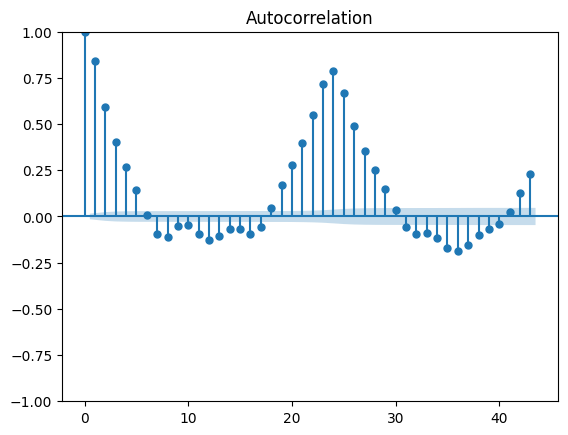

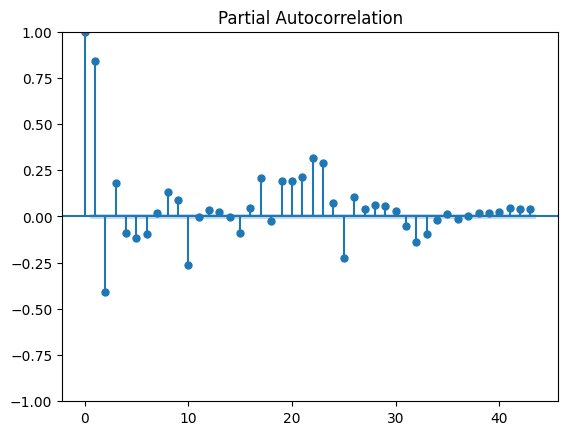

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# ACF: Laat zien hoe de huidige waarde afhankelijk is van eerdere waarden
plot_acf(train_data_final['cnt'])
plt.show()

# PACF: Laat zien welke lags directe invloeden hebben
plot_pacf(train_data_final['cnt'])
plt.show()


In [210]:
print(train_data_final.index.to_series().diff().value_counts())



date_hour
0 days 01:00:00    16365
0 days 02:00:00      141
0 days 03:00:00       18
0 days 13:00:00        1
0 days 23:00:00        1
0 days 07:00:00        1
0 days 14:00:00        1
0 days 04:00:00        1
1 days 13:00:00        1
Name: count, dtype: int64


In [ ]:
# p = 6, q = 5 

In [23]:
# Zorg ervoor dat test_data ook een DatetimeIndex heeft
test_data['date_hour'] = pd.to_datetime(test_data['date_hour'])  # Converteer naar datetime
test_data.set_index('date_hour', inplace=True)  # Stel het in als index
test_data


,holiday,weathersit,temp,atemp,hum,windspeed
date_hour,,,,,,
2012-12-01 00:00:00,0,1,0.26,0.3030,0.81,0.0000
2012-12-01 01:00:00,0,1,0.26,0.3030,0.81,0.0000
2012-12-01 02:00:00,0,2,0.26,0.3030,0.81,0.0000
2012-12-01 03:00:00,0,2,0.26,0.2727,0.81,0.1343
2012-12-01 04:00:00,0,1,0.26,0.2879,0.81,0.0896
...,...,...,...,...,...,...
2012-12-19 19:00:00,0,1,0.38,0.3939,0.50,0.3881
2012-12-19 20:00:00,0,1,0.36,0.3485,0.57,0.2239
2012-12-19 21:00:00,0,1,0.34,0.3182,0.61,0.2239


In [213]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Definieer het model
model = SARIMAX(
    train_data_final['cnt'],  # Doelvariabele
    order=(6, 0, 5),         # Niet-seizoensgebonden parameters
    seasonal_order=(2, 0, 1, 24),  # Seizoensgebonden parameters
    exog=train_data_final[['year', 'month', 'day', 'day_of_week', 'quarter', 'sin_month', 'cos_month']],  # Exogene variabelen
    enforce_stationarity=False,  # Geen extra stationariteit forceren
    enforce_invertibility=False  # Geen extra inversie forceren
)

# Train het model
results = model.fit()

# Print de samenvatting
print(results.summary())


/Users/jip/.pyenv/versions/3.12.7/envs/general/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/jip/.pyenv/versions/3.12.7/envs/general/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.70729D+00    |proj g|=  2.77533D-01


 This problem is unconstrained.



At iterate    5    f=  5.66701D+00    |proj g|=  4.30831D-02

At iterate   10    f=  5.66616D+00    |proj g|=  1.72034D-02

At iterate   15    f=  5.66093D+00    |proj g|=  2.79957D-02

At iterate   20    f=  5.65642D+00    |proj g|=  6.63477D-02

At iterate   25    f=  5.65300D+00    |proj g|=  3.37126D-02

At iterate   30    f=  5.65153D+00    |proj g|=  8.90779D-03

At iterate   35    f=  5.64834D+00    |proj g|=  4.16291D-02

At iterate   40    f=  5.64572D+00    |proj g|=  1.25762D-02

At iterate   45    f=  5.64519D+00    |proj g|=  7.17385D-03

At iterate   50    f=  5.64410D+00    |proj g|=  1.45184D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/jip/.pyenv/versions/3.12.7/envs/general/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                                  cnt   No. Observations:                16531
Model:             SARIMAX(6, 0, 5)x(2, 0, [1], 24)   Log Likelihood              -93302.698
Date:                              Sun, 01 Dec 2024   AIC                         186649.397
Time:                                      11:07:28   BIC                         186819.010
Sample:                                           0   HQIC                        186705.414
                                            - 16531                                         
Covariance Type:                                opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
year            0.0847      0.017      4.959      0.000       0.051       0.118
month           

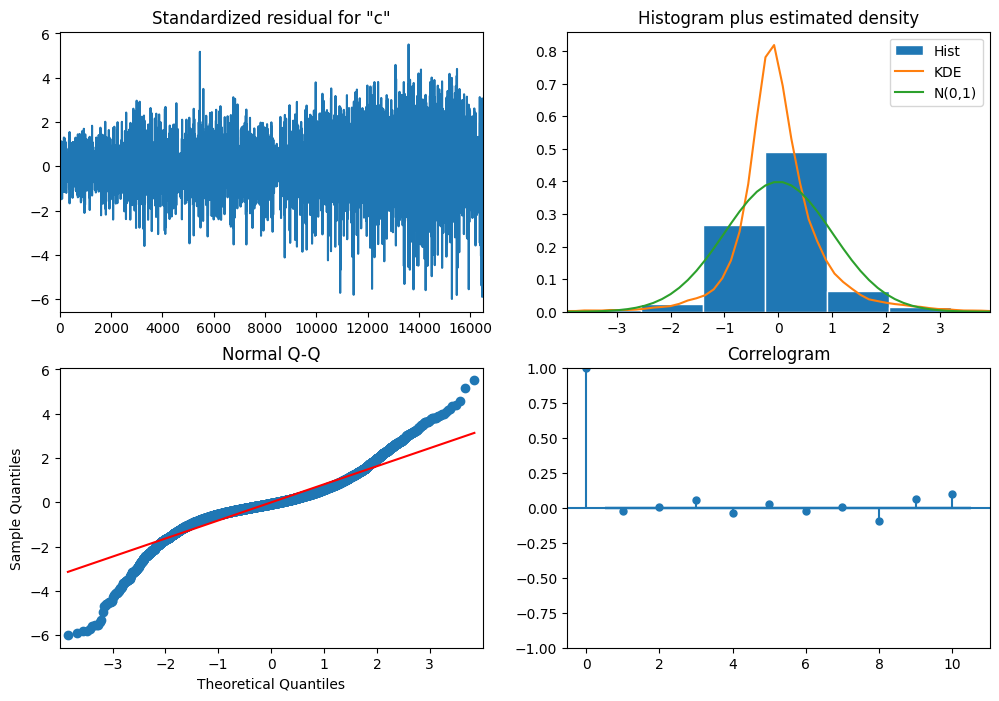

In [214]:
results.plot_diagnostics(figsize=(12, 8))
plt.show()


In [225]:
def create_feature_waves_with_generation(df, waves):
    """
    Maakt iteratief nieuwe dataframes met extra features in golven en genereert de features automatisch.
    """
    dfs = []
    base_features = ['year', 'month', 'day', 'day_of_week', 'quarter', 'sin_month', 'cos_month']  # Basis tijdfeatures
    
    # Basis tijdgerelateerde features berekenen
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
    df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)
    
    current_features = base_features.copy()

    for wave in waves:
        for feature in wave:
            # Logica voor featureberekeningen
            if feature == 'is_weekend':
                df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0)
            elif feature == 'is_holiday':
                df['is_holiday'] = df['day_of_week'].apply(lambda x: 1 if x in [0, 1] else 0)
            elif feature == 'temp_atemp_diff':
                df['temp_atemp_diff'] = df['temp'] - df['atemp']
            elif feature == 'hum_windspeed_interaction':
                df['hum_windspeed_interaction'] = df['hum'] * df['windspeed']
            elif feature == 'temp_windspeed_interaction':
                df['temp_windspeed_interaction'] = df['temp'] * df['windspeed']
            elif feature == 'windspeed_change':
                df['windspeed_change'] = df['windspeed'] - df['windspeed'].shift(1)

        # **Hier voeg je 'cnt' expliciet toe**
        temp_df = df[current_features + ['cnt']].copy()  # Voeg de doelvariabele 'cnt' toe
        current_features.extend(wave)  # Update de huidige featureset
        dfs.append(temp_df)  # Voeg dit nieuwe dataframe toe aan de lijst
    
    return dfs



In [231]:
def train_sarimax_with_waves(df, waves, target, order, seasonal_order):
    """
    Combineert feature-generatie met het trainen van SARIMAX-modellen per wave en slaat modellen op.
    """
    results_per_wave = []
    
    # Genereer de dataframes met de create_feature_waves_with_generation functie
    dfs = create_feature_waves_with_generation(df.copy(), waves)
    
    for idx, wave_df in enumerate(dfs):
        print(f"Wave {idx + 1}: Training SARIMAX met features: {wave_df.columns.tolist()}")
        
        # Model setup
        model = SARIMAX(
            wave_df[target],
            order=order,
            seasonal_order=seasonal_order,
            exog=wave_df[[col for col in wave_df.columns if col != target]],
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        
        results = model.fit(disp=False)
        
        # Opslaan van resultaten, inclusief modelobject
        results_per_wave.append({
            'wave': idx + 1,
            'features': wave_df.columns.tolist(),
            'aic': results.aic,
            'rmse': None,  # RMSE wordt later berekend
            'model': results  # Het daadwerkelijke modelobject opslaan
        })
    
    return results_per_wave


In [232]:
# Waves configureren
waves = [
    ['is_weekend', 'is_holiday'],  # Wave 1: Weekend en feestdagen
    ['temp_atemp_diff', 'hum_windspeed_interaction'],  # Wave 2: Interacties
    ['temp_windspeed_interaction', 'windspeed_change']  # Wave 3: Complexere interacties
]

# SARIMA-parameters instellen
order = (6, 0, 5)
seasonal_order = (2, 0, 1, 24)  # Uurlijkse data met een dagelijkse seizoenscyclus

# Functie om modellen te trainen met waves

def train_sarimax_with_waves(df, waves, target, order, seasonal_order):
    """
    Trains SARIMAX models iteratively for each wave of features and calculates RMSE directly.
    """
    results_per_wave = []
    
    # Genereer de dataframes met de create_feature_waves_with_generation functie
    dfs = create_feature_waves_with_generation(df.copy(), waves)
    
    for idx, wave_df in enumerate(dfs):
        print(f"Wave {idx + 1}: Training SARIMAX met features: {wave_df.columns.tolist()}")
        
        # Model setup
        model = SARIMAX(
            wave_df[target],
            order=order,
            seasonal_order=seasonal_order,
            exog=wave_df[[col for col in wave_df.columns if col != target]],
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        
        results = model.fit(disp=False)
        
        # Voorspellingen maken
        predictions = results.predict(
            start=wave_df.index[0], 
            end=wave_df.index[-1], 
            exog=wave_df[[col for col in wave_df.columns if col != target]]
        )
        
        # RMSE berekenen
        rmse = np.sqrt(mean_squared_error(wave_df[target], predictions))
        
        # Opslaan van resultaten
        results_per_wave.append({
            'wave': idx + 1,
            'features': wave_df.columns.tolist(),
            'aic': results.aic,
            'rmse': rmse,  # RMSE direct toevoegen
            'model': results
        })
    
    return results_per_wave


# Train modellen per wave
results = train_sarimax_with_waves(
    df=train_data_final,  # Originele dataset
    waves=waves,
    target='cnt',
    order=order,
    seasonal_order=seasonal_order
)

# Resultaten bekijken
for result in results:
    print(f"Wave {result['wave']}:")
    print(f"AIC: {result['aic']}")
    print(f"Features: {result['features']}")
    # print(result['summary'])


Wave 1: Training SARIMAX met features: ['year', 'month', 'day', 'day_of_week', 'quarter', 'sin_month', 'cos_month', 'cnt']


/Users/jip/.pyenv/versions/3.12.7/envs/general/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/jip/.pyenv/versions/3.12.7/envs/general/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/jip/.pyenv/versions/3.12.7/envs/general/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Wave 2: Training SARIMAX met features: ['year', 'month', 'day', 'day_of_week', 'quarter', 'sin_month', 'cos_month', 'is_weekend', 'is_holiday', 'cnt']


/Users/jip/.pyenv/versions/3.12.7/envs/general/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/jip/.pyenv/versions/3.12.7/envs/general/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/jip/.pyenv/versions/3.12.7/envs/general/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Wave 3: Training SARIMAX met features: ['year', 'month', 'day', 'day_of_week', 'quarter', 'sin_month', 'cos_month', 'is_weekend', 'is_holiday', 'temp_atemp_diff', 'hum_windspeed_interaction', 'cnt']


/Users/jip/.pyenv/versions/3.12.7/envs/general/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/jip/.pyenv/versions/3.12.7/envs/general/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/jip/.pyenv/versions/3.12.7/envs/general/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Wave 1:
AIC: 186649.39659142832
Features: ['year', 'month', 'day', 'day_of_week', 'quarter', 'sin_month', 'cos_month', 'cnt']


KeyError: 'summary'

In [235]:
for result in results:
    print(f"Wave {result['wave']}:")
    print(f"RMSE: {result['rmse']}")
    print(f"Features: {result['features']}")

Wave 1:
RMSE: 67.10879361041049
Features: ['year', 'month', 'day', 'day_of_week', 'quarter', 'sin_month', 'cos_month', 'cnt']
Wave 2:
RMSE: 67.08401496448438
Features: ['year', 'month', 'day', 'day_of_week', 'quarter', 'sin_month', 'cos_month', 'is_weekend', 'is_holiday', 'cnt']
Wave 3:
RMSE: 68.91192022017457
Features: ['year', 'month', 'day', 'day_of_week', 'quarter', 'sin_month', 'cos_month', 'is_weekend', 'is_holiday', 'temp_atemp_diff', 'hum_windspeed_interaction', 'cnt']


## Prophet

In [253]:
df_prophet = train_data_cleaned.copy()
df_prophet.reset_index(inplace=True)

# Rename de kolommen naar Prophet's formaat
df_prophet = df_prophet.rename(columns={'cnt': 'y'})
df_prophet = df_prophet.rename(columns={'date_hour': 'ds'})
# Bekijk de data om te controleren of alles klopt
display(df_prophet.head())


,ds,holiday,weathersit,temp,atemp,hum,windspeed,y
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,16
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,40
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,32
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,13
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,1


In [254]:
# Stel een Prophet-model op met regressoren
from prophet import Prophet

model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False  # Uitzetten als het niet relevant is
)

# Voeg regressoren toe
model.add_regressor('holiday')
model.add_regressor('weathersit')
model.add_regressor('temp')
model.add_regressor('atemp')
model.add_regressor('hum')
model.add_regressor('windspeed')

# Train het model
model.fit(df_prophet)


13:31:06 - cmdstanpy - INFO - Chain [1] start processing
13:31:08 - cmdstanpy - INFO - Chain [1] done processing


In [264]:
future = model.make_future_dataframe(periods=30, freq='h')
future

,ds
0,2011-01-01 00:00:00
1,2011-01-01 01:00:00
2,2011-01-01 02:00:00
3,2011-01-01 03:00:00
4,2011-01-01 04:00:00
...,...
16556,2012-12-02 01:00:00
16557,2012-12-02 02:00:00
16558,2012-12-02 03:00:00
16559,2012-12-02 04:00:00


In [265]:
# Maak een DataFrame met toekomstige datums (bijv. 30 uur vooruit)
future = model.make_future_dataframe(periods=30, freq='h')  # 'H' voor uur
future = future.merge(df_prophet[['ds', 'holiday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']], on='ds', how='left')
for col in ['temp', 'atemp', 'hum', 'windspeed']:
    future[col].fillna(df_prophet[col].mean(), inplace=True)
for col in ['holiday', 'weathersit']:
    future[col].fillna(df_prophet[col].mode()[0], inplace=True)




# Controleer de toekomstige data
print(future.tail())


                       ds  holiday  weathersit      temp     atemp       hum  \
16556 2012-12-02 01:00:00      0.0         1.0  0.505204  0.482984  0.623953   
16557 2012-12-02 02:00:00      0.0         1.0  0.505204  0.482984  0.623953   
16558 2012-12-02 03:00:00      0.0         1.0  0.505204  0.482984  0.623953   
16559 2012-12-02 04:00:00      0.0         1.0  0.505204  0.482984  0.623953   
16560 2012-12-02 05:00:00      0.0         1.0  0.505204  0.482984  0.623953   

       windspeed  
16556   0.190742  
16557   0.190742  
16558   0.190742  
16559   0.190742  
16560   0.190742  


/var/folders/8q/6_g2kyj573j54w4wmj33_h680000gn/T/ipykernel_35319/3469872355.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  future[col].fillna(df_prophet[col].mean(), inplace=True)
/var/folders/8q/6_g2kyj573j54w4wmj33_h680000gn/T/ipykernel_35319/3469872355.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting val

In [266]:
# Maak voorspellingen
forecast = model.predict(future)

# Bekijk de voorspellingen
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])


                       ds        yhat  yhat_lower  yhat_upper
0     2011-01-01 00:00:00  -33.919260 -219.673248  138.377878
1     2011-01-01 01:00:00  -42.075810 -228.008113  149.515976
2     2011-01-01 02:00:00  -41.922141 -223.992107  139.559328
3     2011-01-01 03:00:00  -17.506496 -199.304275  186.912874
4     2011-01-01 04:00:00  -17.368728 -200.911954  175.575480
...                   ...         ...         ...         ...
16556 2012-12-02 01:00:00  320.107755  148.765126  514.979351
16557 2012-12-02 02:00:00  319.948017  132.634432  496.275514
16558 2012-12-02 03:00:00  319.767691  124.261226  508.079495
16559 2012-12-02 04:00:00  319.567642  116.704634  504.400397
16560 2012-12-02 05:00:00  319.348932  139.564511  517.456919

[16561 rows x 4 columns]


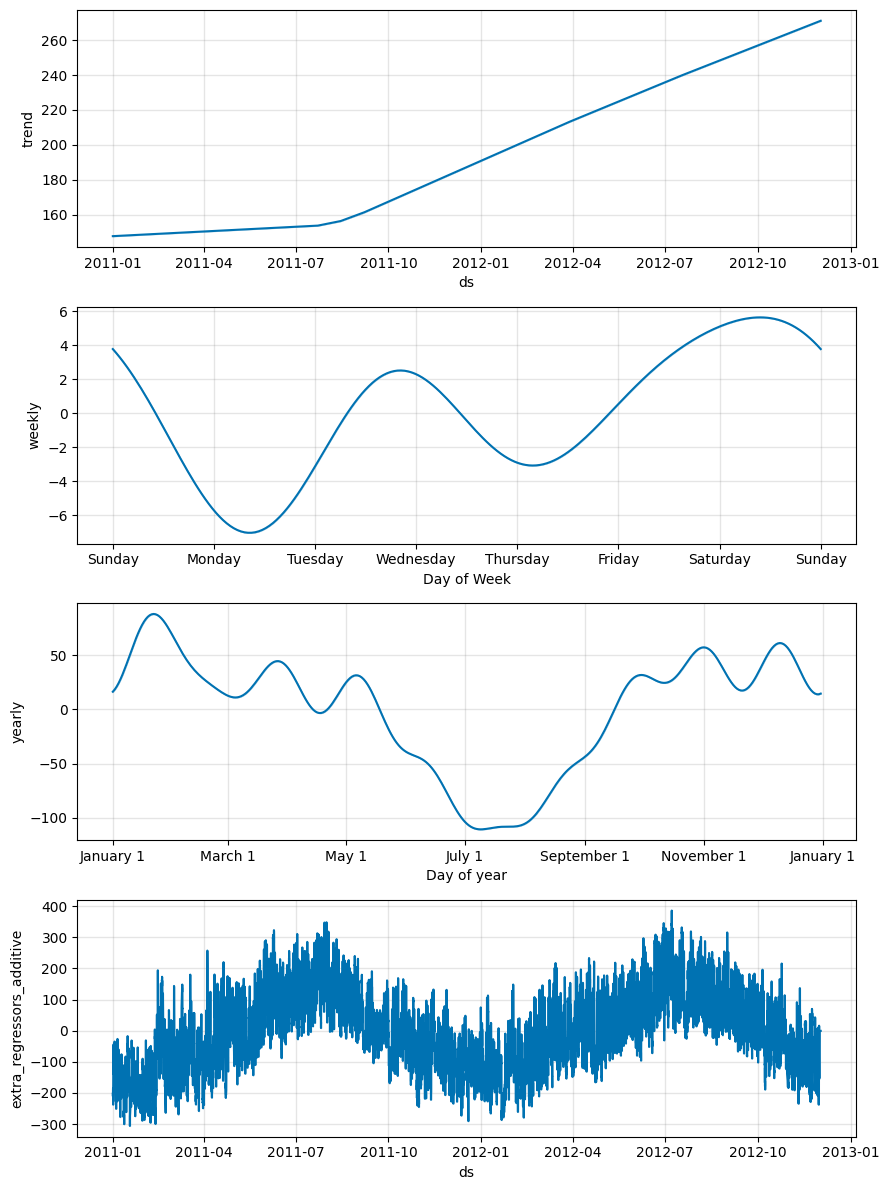

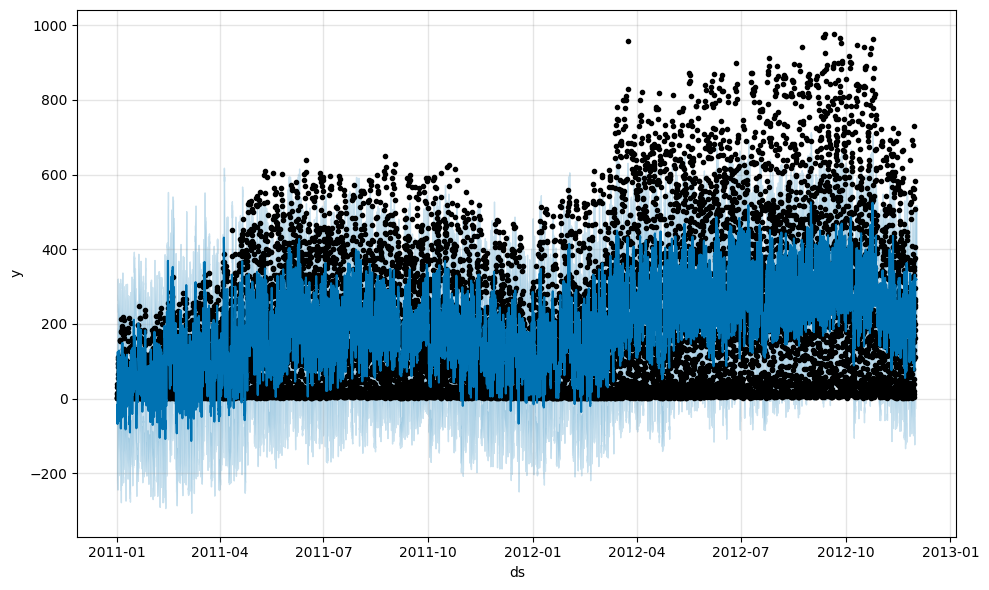

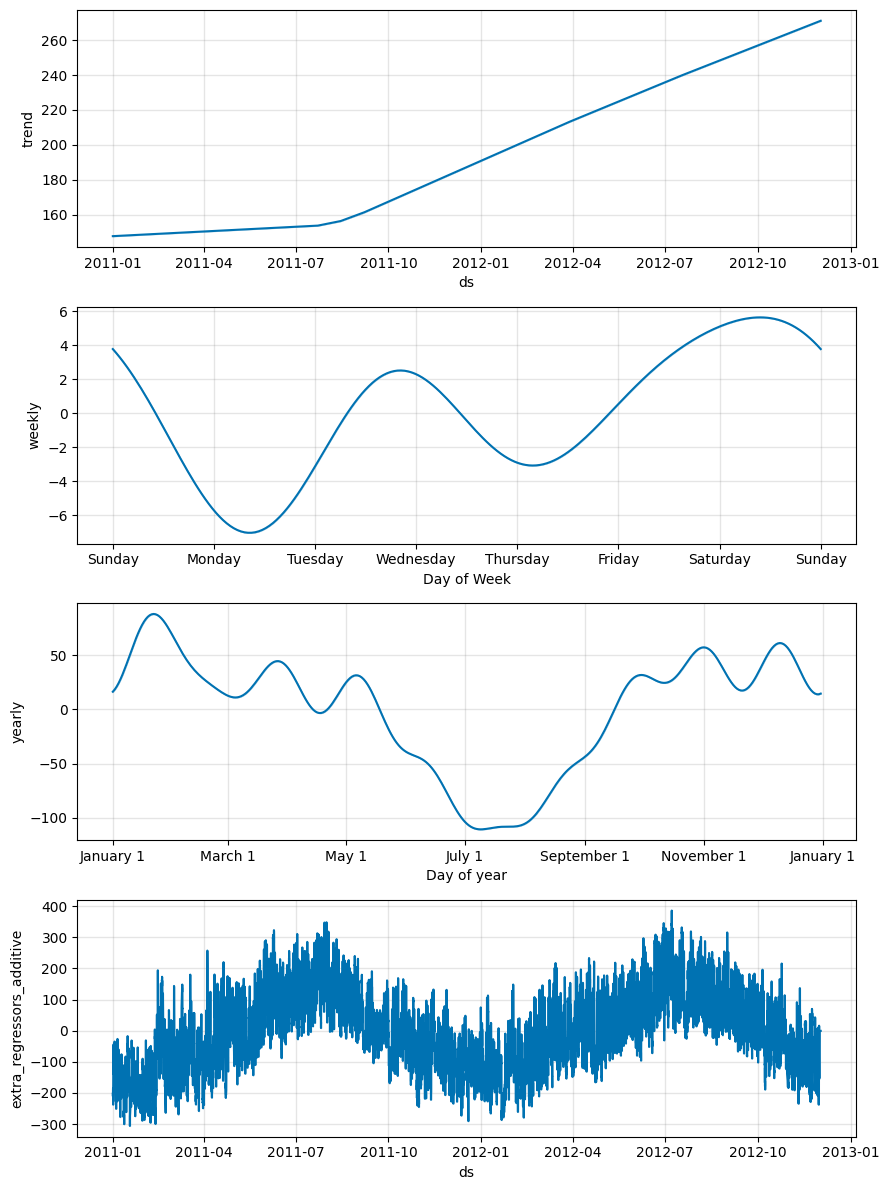

In [267]:
# Voorspellingen plotten
model.plot(forecast)

# Componenten bekijken
model.plot_components(forecast)


## Hybrid (waves)

In [241]:
def train_hybrid_with_waves(df, waves, target):
    """
    Trains a hybrid model (Linear Regression + Decision Tree) iteratively for each wave of features and calculates RMSE.
    """
    results_per_wave = []

    # Genereer de dataframes met de create_feature_waves_with_generation functie
    dfs = create_feature_waves_with_generation(df.copy(), waves)
    
    for idx, wave_df in enumerate(dfs):
        print(f"Wave {idx + 1}: Training hybride model met features: {wave_df.columns.tolist()}")

        # Data splitsen
        X = wave_df.drop(columns=[target])
        y = wave_df[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=7*24, shuffle=False)
        
        # Eerste model (Lineaire Regressie)
        model1 = LinearRegression()
        model1.fit(X_train, y_train)
        train_predict1 = model1.predict(X_train)
        test_predict1 = model1.predict(X_test)
        
        # Residuen berekenen
        y_train_res = y_train - train_predict1
        y_test_res = y_test - test_predict1

        # Tweede model (Decision Tree met GridSearchCV)
        param_grid = {
            'max_depth': [3, 5, 10, 15],
            'min_samples_split': [2, 5, 10, 15],
            'min_samples_leaf': [1, 2, 4, 6]
        }
        grid_search = GridSearchCV(
            DecisionTreeRegressor(),
            param_grid,
            cv=TimeSeriesSplit(n_splits=5),
            scoring='neg_mean_squared_error'
        )
        grid_search.fit(X_train, y_train_res)

        # Beste model selecteren en trainen
        model2 = grid_search.best_estimator_
        model2.fit(X_train, y_train_res)

        # Totale voorspellingen maken
        train_predictions_total = train_predict1 + model2.predict(X_train)
        test_predictions_total = test_predict1 + model2.predict(X_test)

        # RMSE berekenen
        train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions_total))
        test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions_total))
        
        # Opslaan van resultaten
        results_per_wave.append({
            'wave': idx + 1,
            'features': wave_df.columns.tolist(),
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'best_params': grid_search.best_params_,
            'model1': model1,
            'model2': model2
        })
        
        print(f"Wave {idx + 1}: Train RMSE={train_rmse:.2f}, Test RMSE={test_rmse:.2f}, Best Params={grid_search.best_params_}")

    return results_per_wave


# Waves configureren
waves = [
    ['is_weekend', 'is_holiday'],  # Wave 1
    ['temp_atemp_diff', 'hum_windspeed_interaction'],  # Wave 2
    ['temp_windspeed_interaction', 'windspeed_change']  # Wave 3
]

# Train het hybride model per wave
results = train_hybrid_with_waves(
    df=train_data_cleaned,  # Originele dataset
    waves=waves,
    target='cnt'
)

# Resultaten bekijken
for result in results:
    print(f"Wave {result['wave']}:")
    print(f"Train RMSE: {result['train_rmse']:.2f}, Test RMSE: {result['test_rmse']:.2f}")
    print(f"Features: {result['features']}")
    print(f"Beste hyperparameters voor Decision Tree: {result['best_params']}")


Wave 1: Training hybride model met features: ['year', 'month', 'day', 'day_of_week', 'quarter', 'sin_month', 'cos_month', 'cnt']
Wave 1: Train RMSE=167.92, Test RMSE=166.61, Best Params={'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 15}
Wave 2: Training hybride model met features: ['year', 'month', 'day', 'day_of_week', 'quarter', 'sin_month', 'cos_month', 'is_weekend', 'is_holiday', 'cnt']
Wave 2: Train RMSE=167.90, Test RMSE=165.17, Best Params={'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10}
Wave 3: Training hybride model met features: ['year', 'month', 'day', 'day_of_week', 'quarter', 'sin_month', 'cos_month', 'is_weekend', 'is_holiday', 'temp_atemp_diff', 'hum_windspeed_interaction', 'cnt']
Wave 3: Train RMSE=164.57, Test RMSE=170.87, Best Params={'max_depth': 3, 'min_samples_leaf': 6, 'min_samples_split': 2}
Wave 1:
Train RMSE: 167.92, Test RMSE: 166.61
Features: ['year', 'month', 'day', 'day_of_week', 'quarter', 'sin_month', 'cos_month', 'cnt']
Best

## Hybride model

- **Hoe werkt een hybride model?**

    Een hybride model is een model dat bestaat uit meerdere modellen. Elk manchine learning model heeft zijn sterke en zwakke punten. Een hybride model combineert de sterke punten van de modellen om zo de beste voorspelling te maken.

    Om de werking van een hybride model goed te snappen wordt deze hier stapsgewijs uitgelegd.

    1. Een model doet de eerste voorspelling. Een willekeurig model wordt gekozen om de eerste voorspelling te doen en simpele patronen in de dataset te vinden en te voorspellen.

    2. Het tweede model corrigeerd de foute voorspellingen. Een tweede model wordt gebruikt om de fouten van het eerste model (ookwel residuen genoemd) te herkennen en te verbeteren waar mogelijk.

    3. De uiteindelijke voorspelling van het hybride model is zo dus een combinatie van de voorspellingen van het eerste model en de verbeteringen die het tweede model heeft gedaan. 


In [206]:
train_data_hybrid = train_data_cleaned.copy()

train_data_hybrid['year'] = train_data_hybrid.index.year
train_data_hybrid['month'] = train_data_hybrid.index.month
train_data_hybrid['day'] = train_data_hybrid.index.day
train_data_hybrid['day_of_week'] = train_data_hybrid.index.dayofweek
train_data_hybrid['quarter'] = train_data_hybrid.index.quarter

# Frequenties instellen
train_data_hybrid['sin_month'] = np.sin(2 * np.pi * train_data_hybrid['month'] / 12)
train_data_hybrid['cos_month'] = np.cos(2 * np.pi * train_data_hybrid['month'] / 12)
train_data_hybrid['sin_day_of_week'] = np.sin(2 * np.pi * train_data_hybrid['day_of_week'] / 7)
train_data_hybrid['cos_day_of_week'] = np.cos(2 * np.pi * train_data_hybrid['day_of_week'] / 7)

# Selecteer features en target
X = train_data_hybrid.drop(columns=['cnt'])
y = train_data_hybrid['cnt']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=7*24, shuffle=False)

# Eerste model (Lineaire Regressie)
model1 = LinearRegression()
model1.fit(X_train, y_train)
train_predict1 = model1.predict(X_train)
test_predict1 = model1.predict(X_test)

# Residuen berekenen
y_train_res = y_train - train_predict1
y_test_res = y_test - test_predict1

# Tweede model (Decision Tree)
param_grid = {
    'max_depth': [3, 5, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6]
}

grid_search = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=TimeSeriesSplit(n_splits=10), scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train_res)

model2 = grid_search.best_estimator_
model2.fit(X_train, y_train_res)

# Totale voorspellingen
train_predictions_total = train_predict1 + model2.predict(X_train)
test_predictions_total = test_predict1 + model2.predict(X_test)

print(f'{grid_search.best_params_}')
print('Train RMSE:', np.sqrt(mean_squared_error(y_train, train_predictions_total)))
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, test_predictions_total)))


{'max_depth': 3, 'min_samples_leaf': 6, 'min_samples_split': 5}
Train RMSE: 148.1437501287602
Test RMSE: 166.32282854052352


## Kaggle submission functie

In [287]:
# Aanmaken van submissionfucntie
def kaggle_submission(model, test_data, wedstrijdnaam,
                     bestandsnaam="submission.csv", bericht="Model submission", prophet=False):
    """
    Maakt en levert een submission bestand in voor Kaggle.

    Parameters:
    - model: het getrainde model dat wordt gebruikt voor voorspellingen.
    - test_data: Pandas DataFrame met de testdata van Kaggle.
    - kolommen_verwijderen: Lijst met kolommen die uit de testdata verwijderd moeten worden.
    - scaler: Een scaler object (bijv. StandardScaler of MinMaxScaler) om de testdata te schalen.
    - wedstrijdnaam: Naam van de Kaggle competitie.
    - bestandsnaam: Naam van het output submissionbestand (standaard: "submission.csv").
    - bericht: Bericht dat meegestuurd wordt bij het indienen (standaard: "Model submission").

    Returns:
    - Geen, maar slaat een bestand op en dient het in via de kaggle API.
    """

    # Maken van voorspellingen
    y_pred_kaggle = model.predict(test_data)
    
    if prophet:
        submission = pd.DataFrame({
            'date_hour': test_data['ds'],
            'cnt': forecast['yhat']
            })

    else:
    # Aanmaken van submission DataFrame
        submission = pd.DataFrame({
            'date_hour': test_data.index,
            'cnt': y_pred_kaggle.flatten()
            })
    
    # Oplsaan van submissionbestand
    submission.to_csv(bestandsnaam, index=False)
    print(f"Submissionbestand {bestandsnaam} succesvol opgeslagen.")
    
    # Indienen via de Kaggle API
    os.system(f'kaggle competitions submit -c {wedstrijdnaam} -f {bestandsnaam} -m "{bericht}"')
    print(f"Submission ingediend voor wedstrijd: {wedstrijdnaam}.")

In [196]:
from sklearn.preprocessing import StandardScaler

# Fit the scaler on the training data
# scaler = StandardScaler()
# scaler.fit(test_data)

kaggle_submission(
    model=wow3.model,  # Gebruik je getrainde model
    test_data=test_data,  # Test dataset van kaggle
    # kolommen_verwijderen=['id', 'gender_Other', 'work_type_children', 'ever_married_No', 'ever_married_Yes'],  # Te verwijderen kolommen
    # scaler=scaler,  # Gebruikte scaler om de data te normaliseren
    wedstrijdnaam="voorspellen-van-verhuuraantallen",  # Naam van de kaggle competitie
    bestandsnaam="submission.csv",  # Bestandsnaam voor de submission
    bericht="Born to be Alive is niet van de Village People"  # Bericht bij het indienen
)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- date_hour
Feature names seen at fit time, yet now missing:
- trend


In [162]:
import os
import pandas as pd

def kaggle_submission_hybrid(model, test_data, wedstrijdnaam, 
                      bestandsnaam="submission.csv", bericht="Model submission", 
                      hybrid=False, model2=None):
    """
    Maakt en levert een submission bestand in voor Kaggle.

    Parameters:
    - model: Het eerste getrainde model (bijvoorbeeld een lineaire regressie).
    - test_data: Pandas DataFrame met de testdata van Kaggle.
    - wedstrijdnaam: Naam van de Kaggle competitie.
    - bestandsnaam: Naam van het output submissionbestand (standaard: "submission.csv").
    - bericht: Bericht dat meegestuurd wordt bij het indienen (standaard: "Model submission").
    - hybrid: Boolean, geeft aan of een hybride model wordt gebruikt (standaard: False).
    - model2: Het tweede model dat wordt gebruikt bij een hybride model (standaard: None).

    Returns:
    - Geen, maar slaat een bestand op en dient het in via de Kaggle API.
    """

    if hybrid:
        # Hybride model: gebruik zowel model1 als model2
        if model2 is None:
            raise ValueError("Voor een hybride model moet model2 worden opgegeven.")
        
        # Voorspellingen van het eerste model
        pred1 = model.predict(test_data)

        # Voorspellingen van het tweede model
        pred2 = model2.predict(test_data)

        # Combineer de voorspellingen
        y_pred_kaggle = pred1 + pred2
    else:
        # Enkelvoudig model
        y_pred_kaggle = model.predict(test_data)

    # Aanmaken van submission DataFrame
    submission = pd.DataFrame({
        'date_hour': test_data.index,
        'cnt': y_pred_kaggle.flatten()
    })

    # Oplsaan van submissionbestand
    submission.to_csv(bestandsnaam, index=False)
    print(f"Submissionbestand {bestandsnaam} succesvol opgeslagen.")
    
    # Indienen via de Kaggle API
    os.system(f'kaggle competitions submit -c {wedstrijdnaam} -f {bestandsnaam} -m "{bericht}"')
    print(f"Submission ingediend voor wedstrijd: {wedstrijdnaam}.")


In [207]:
# Voorbereiding van test_data (met dezelfde feature engineering als voor train_data)
test_data_hybrid = test_data.copy()
test_data_hybrid['date_hour'] = pd.to_datetime(test_data_hybrid['date_hour'])  # Converteer naar datetime
test_data_hybrid.set_index('date_hour', inplace=True)
test_data_hybrid['year'] = test_data_hybrid.index.year
test_data_hybrid['month'] = test_data_hybrid.index.month
test_data_hybrid['day'] = test_data_hybrid.index.day
test_data_hybrid['day_of_week'] = test_data_hybrid.index.dayofweek
test_data_hybrid['quarter'] = test_data_hybrid.index.quarter

# Frequenties instellen
test_data_hybrid['sin_month'] = np.sin(2 * np.pi * test_data_hybrid['month'] / 12)
test_data_hybrid['cos_month'] = np.cos(2 * np.pi * test_data_hybrid['month'] / 12)
test_data_hybrid['sin_day_of_week'] = np.sin(2 * np.pi * test_data_hybrid['day_of_week'] / 7)
test_data_hybrid['cos_day_of_week'] = np.cos(2 * np.pi * test_data_hybrid['day_of_week'] / 7)


# Submit met hybride model
kaggle_submission_hybrid(
    model=model1,
    model2=model2,
    test_data=test_data_hybrid,
    wedstrijdnaam="bike-sharing-demand",
    bestandsnaam="hybrid_submission.csv",
    bericht="Hybrid model submission",
    hybrid=True
)


Submissionbestand hybrid_submission.csv succesvol opgeslagen.
Submission ingediend voor wedstrijd: bike-sharing-demand.


sh: kaggle: command not found


## **Bronnenlijst**
- OpenAI. (2024, 29 november). https://chatgpt.com/share/e/674b33d3-a97c-8005-a780-d15b31ab046f
- OpenAI. (2024, 30 november). https://chatgpt.com/share/e/674b3696-0988-8005-95d7-074ca3415925
- OpenAI. (2024, 30 november). https://chatgpt.com/share/e/674b390c-d89c-8005-83b3-b04e65ebb7b9
- DecisionTreeRegressor. (n.d.). Scikit-learn. https://scikit-learn.org/dev/modules/generated/sklearn.tree.DecisionTreeRegressor.html
- GradientBoostingClassifier. (z.d.). Scikit-learn. https://scikit-learn.org/dev/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
- RandomForestRegressor. (n.d.). Scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
- GradientBoostingClassifier. (z.d.-b). Scikit-learn. https://scikit-learn.org/dev/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html


In [275]:
test_data

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed
0,2012-12-01 00:00:00,0,1,0.26,0.3030,0.81,0.0000
1,2012-12-01 01:00:00,0,1,0.26,0.3030,0.81,0.0000
2,2012-12-01 02:00:00,0,2,0.26,0.3030,0.81,0.0000
3,2012-12-01 03:00:00,0,2,0.26,0.2727,0.81,0.1343
4,2012-12-01 04:00:00,0,1,0.26,0.2879,0.81,0.0896
...,...,...,...,...,...,...,...
451,2012-12-19 19:00:00,0,1,0.38,0.3939,0.50,0.3881
452,2012-12-19 20:00:00,0,1,0.36,0.3485,0.57,0.2239
453,2012-12-19 21:00:00,0,1,0.34,0.3182,0.61,0.2239
454,2012-12-19 22:00:00,0,1,0.34,0.3485,0.61,0.0896


In [280]:
# Zorg ervoor dat 'test_data' een kolom 'ds' bevat
# Voeg eventuele regressoren toe aan 'test_data', net als bij de future DataFrame
# Hernoem de 'date_hour' kolom naar 'ds' zodat Prophet het herkent
test_data = pd.read_csv('test.csv')
test_data['date_hour'] = pd.to_datetime(test_data['date_hour'])
test_data = test_data.rename(columns={'date_hour': 'ds'})
test_data = test_data.merge(df_prophet[['ds', 'holiday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']], on='ds', how='left')

# Behoud alleen de correcte versies (de '_x'-kolommen)
test_data = test_data[['ds', 'holiday_x', 'weathersit_x', 'temp_x', 'atemp_x', 'hum_x', 'windspeed_x']]

# Hernoem de '_x'-kolommen naar hun oorspronkelijke namen
test_data.rename(columns={
    'holiday_x': 'holiday',
    'weathersit_x': 'weathersit',
    'temp_x': 'temp',
    'atemp_x': 'atemp',
    'hum_x': 'hum',
    'windspeed_x': 'windspeed'
}, inplace=True)

# Vul ontbrekende waarden in
test_data['holiday'].fillna(0, inplace=True)
test_data['weathersit'].fillna(df_prophet['weathersit'].mode()[0], inplace=True)
test_data['temp'].fillna(df_prophet['temp'].mean(), inplace=True)
test_data['atemp'].fillna(df_prophet['atemp'].mean(), inplace=True)
test_data['hum'].fillna(df_prophet['hum'].mean(), inplace=True)
test_data['windspeed'].fillna(df_prophet['windspeed'].mean(), inplace=True)

# Maak voorspellingen
forecast = model.predict(test_data)

# Voeg 'yhat' (voorspelde waarden) toe aan test_data
test_data['yhat'] = forecast['yhat']


/var/folders/8q/6_g2kyj573j54w4wmj33_h680000gn/T/ipykernel_35319/1657843675.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['holiday'].fillna(0, inplace=True)
/var/folders/8q/6_g2kyj573j54w4wmj33_h680000gn/T/ipykernel_35319/1657843675.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

In [283]:
test_data

,ds,holiday,weathersit,temp,atemp,hum,windspeed,yhat
0,2012-12-01 00:00:00,0,1,0.26,0.3030,0.81,0.0000,127.011276
1,2012-12-01 01:00:00,0,1,0.26,0.3030,0.81,0.0000,127.265462
2,2012-12-01 02:00:00,0,2,0.26,0.3030,0.81,0.0000,128.646874
3,2012-12-01 03:00:00,0,2,0.26,0.2727,0.81,0.1343,130.488612
4,2012-12-01 04:00:00,0,1,0.26,0.2879,0.81,0.0896,129.681306
...,...,...,...,...,...,...,...,...
451,2012-12-19 19:00:00,0,1,0.38,0.3939,0.50,0.3881,282.630455
452,2012-12-19 20:00:00,0,1,0.36,0.3485,0.57,0.2239,242.387273
453,2012-12-19 21:00:00,0,1,0.34,0.3182,0.61,0.2239,218.580991
454,2012-12-19 22:00:00,0,1,0.34,0.3485,0.61,0.0896,216.678046


In [288]:
kaggle_submission(
    model=model,  # Je getrainde Prophet-model
    test_data=test_data,  # Testdata met de 'ds'-kolom
    wedstrijdnaam="voorspellen-van-verhuuraantallen",
    bestandsnaam="submission.csv",
    bericht="Born to be Alive is niet van de Village People", prophet=True
)

Submissionbestand submission.csv succesvol opgeslagen.
Submission ingediend voor wedstrijd: voorspellen-van-verhuuraantallen.


sh: kaggle: command not found
